# **Análisis y Clasificación de Tweets de Desastres Usando BERT**

**Contexto**

El conjunto de datos contiene más de 11,000 tweets asociados con palabras clave relacionadas con desastres como "accidente", "cuarentena" y "incendios forestales", así como la ubicación y la palabra clave en sí. Estos tweets fueron recopilados el 14 de enero de 2020 y abarcan una variedad de temas relevantes, tales como:
*   La erupción del volcán Taal en Batangas, Filipinas
*   Coronavirus
*   Incendios forestales en Australia
*   La caída del vuelo PS752 en Irán

La intención de este análisis es enriquecer los datos disponibles para este tema con tweets nuevos y clasificados manualmente. El conjunto de datos original, "Disasters on Social Media", se utilizó en la competencia "Real or Not? NLP with Disaster Tweets" en Kaggle.

**Objetivo**

El objetivo de este notebook es aplicar técnicas de procesamiento de lenguaje natural (NLP) y aprendizaje profundo (Deep Learning) para clasificar tweets en dos categorías: Desastre y No Desastre. Utilizando el modelo BERT, que es uno de los modelos de lenguaje más avanzados, se entrenará un modelo de clasificación para predecir si un tweet está relacionado con un desastre o no.

# Parte 1: Importar Librerías

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns


Esta sección importa las librerías necesarias para el procesamiento de datos, modelado, y visualización.
*   numpy y pandas son utilizados para la manipulación de datos.
*   tensorflow y transformers proporcionan herramientas para el modelado y la tokenización con BERT.
*   sklearn para la división de datos en conjuntos de entrenamiento y prueba.
*   matplotlib y seaborn se usan para la visualización de resultados.

# Parte 2: Cargar y Preprocesar el Dataset

In [10]:
# Cargar dataset
url = "https://raw.githubusercontent.com/flordelarosa/TD-delaRosa/main/tweets_disaster.csv"
data = pd.read_csv(url)

# Reducir el tamaño del dataset para pruebas rápidas (opcional)
data = data.sample(n=1000, random_state=42)  # Usar solo 1000 ejemplos

# Usar solo las columnas necesarias (texto y etiqueta)
data = data[['text', 'target']]

# Mostrar las primeras filas del dataset
print("Primeras filas del dataset:")
print(data.head())

Primeras filas del dataset:
                                                    text  target
3495   How many illegal buildings should be demolishe...       0
5461                     Who’s fatality is this tho ????       0
9794   #OnThisDay 2018 Chinese state media confirmed ...       1
11105  With any luck you will miss the windstorm on e...       0
1803   Inferno on Black Friday 1939: 71 deaths, 3,700...       1


En esta sección:
*   Se carga el dataset desde una URL proporcionada.
*   Para pruebas rápidas y reducir el tiempo de entrenamiento, se toma una muestra de 1000 ejemplos (opcional).
*   Se seleccionan solo las columnas relevantes: text (texto del tweet) y target (etiqueta de desastre).
*   Se muestran las primeras filas del dataset para verificar su contenido.








# Parte 3: Inicializar el Tokenizador y Preparar los Datos para BERT

In [11]:
# Inicializar el tokenizador BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenización y preparación de los datos
def preparar_bert_input(textos, max_len=64):  # Reducido de 100 a 64
    encodings = tokenizer(textos.tolist(), truncation=True, padding='max_length', max_length=max_len, return_tensors="tf")
    return encodings['input_ids'], encodings['attention_mask']

# Preparar las entradas para BERT
input_ids, attention_masks = preparar_bert_input(data['text'])

# Convertir las etiquetas a un array de NumPy
labels = np.array(data['target'])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Explicación:
*   Se inicializa el tokenizador BERT, que convierte texto en identificadores numéricos que BERT puede procesar.
*   La función preparar_bert_input tokeniza los textos y crea máscaras de atención, limitando la longitud a 64 tokens para eficiencia.
*   Se preparan las entradas para el modelo BERT y se convierten las etiquetas a un array de NumPy para el entrenamiento.






# Parte 4: Dividir los Datos en Conjunto de Entrenamiento y Prueba

In [12]:
# Dividir los datos en conjunto de entrenamiento y prueba
input_ids_train, input_ids_test, attention_masks_train, attention_masks_test, y_train, y_test = train_test_split(
    input_ids.numpy(), attention_masks.numpy(), labels, test_size=0.2, random_state=42
)

# Convertir arrays de numpy a tensores de TensorFlow
input_ids_train = tf.convert_to_tensor(input_ids_train, dtype=tf.int32)
input_ids_test = tf.convert_to_tensor(input_ids_test, dtype=tf.int32)
attention_masks_train = tf.convert_to_tensor(attention_masks_train, dtype=tf.int32)
attention_masks_test = tf.convert_to_tensor(attention_masks_test, dtype=tf.int32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)


Explicación:
*   Se dividen los datos en conjuntos de entrenamiento y prueba utilizando una proporción del 20% para la prueba.
*   Se convierten los arrays de NumPy en tensores de TensorFlow, que son el formato esperado para el entrenamiento del modelo.

# Parte 5: Definir y Compilar el Modelo

In [13]:
# Inicializar el modelo BERT base
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Definir una capa personalizada que llama a BERT
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        return self.bert_model([input_ids, attention_mask])[0]

# Definir la arquitectura del modelo
input_ids_layer = layers.Input(shape=(input_ids_train.shape[1],), dtype=tf.int32, name="input_ids")
attention_mask_layer = layers.Input(shape=(attention_masks_train.shape[1],), dtype=tf.int32, name="attention_mask")

# Usar la capa personalizada de BERT
bert_output = BertLayer(bert_model)([input_ids_layer, attention_mask_layer])

# Capa de GlobalMaxPooling
x = layers.GlobalMaxPooling1D()(bert_output)

# Añadir capas densas adicionales
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)

# Capa final de salida
output = layers.Dense(2, activation='softmax')(x)

# Definir el modelo completo
modelo_completo = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=output)

# Compilar el modelo
modelo_completo.compile(optimizer=Adam(learning_rate=5e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Explicación:
*   Se inicializa el modelo BERT base.
*   Se define una capa personalizada BertLayer que envuelve el modelo BERT y procesa las entradas.
*   Se construye la arquitectura del modelo agregando una capa de GlobalMaxPooling, capas densas, y una capa de salida con activación softmax para la clasificación binaria.
*   Finalmente, se compila el modelo con un optimizador Adam y una función de pérdida sparse_categorical_crossentropy.






# Parte 6: Entrenar el Modelo

In [14]:
# Entrenar el modelo
historial = modelo_completo.fit(
    [input_ids_train, attention_masks_train], y_train,
    validation_data=([input_ids_test, attention_masks_test], y_test),
    epochs=2,  # Reducido de 3 a 2 épocas
    batch_size=64  # Aumentado de 32 a 64
)

Epoch 1/2
13/13 ━━━━━━━━━━━━━━━━━━━━ 257s 19s/step - accuracy: 0.5434 - loss: 0.7812 - val_accuracy: 0.8400 - val_loss: 0.4240
Epoch 2/2
13/13 ━━━━━━━━━━━━━━━━━━━━ 260s 18s/step - accuracy: 0.8090 - loss: 0.5589 - val_accuracy: 0.8400 - val_loss: 0.4270


*   Se entrena el modelo utilizando el conjunto de entrenamiento y se valida con el conjunto de prueba.
*   Se ajustan los parámetros de entrenamiento como el número de épocas (2) y el tamaño del batch (64) para evaluar el modelo más rápidamente.





*   Mejora en Precisión de Entrenamiento: Subió de 54.34% a 80.90%.
*   Disminución en Pérdida de Entrenamiento: Pasó de 0.7812 a 0.5589.
*   Precisión de Validación Constante: Se mantuvo en 84.00%.
*   Ligero Aumento en Pérdida de Validación: Subió de 0.4240 a 0.4270.

El modelo mejoró en el entrenamiento, pero la precisión de validación se mantuvo constante, con una ligera variabilidad en la pérdida de validación. Se recomienda seguir monitorizando el rendimiento y considerar ajustes si es necesario.

# Parte 7: Evaluar el Modelo y Visualizar Resultados

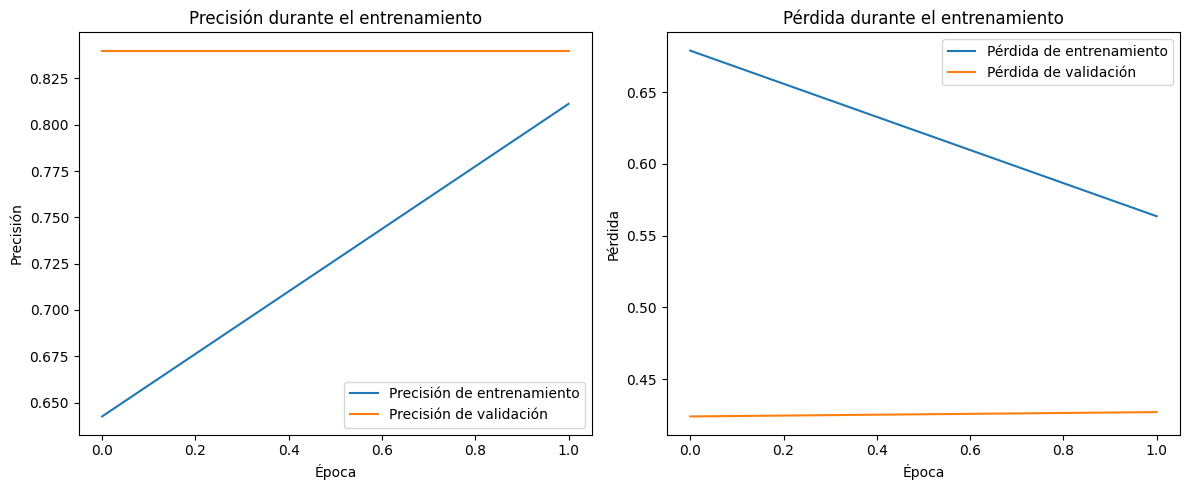

7/7 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step
                                               Texto  Real  Predicción
0  How many illegal buildings should be demolishe...     0           0
1                    Who’s fatality is this tho ????     0           0
2  #OnThisDay 2018 Chinese state media confirmed ...     0           0
3  With any luck you will miss the windstorm on e...     1           0
4  Inferno on Black Friday 1939: 71 deaths, 3,700...     1           0


<ipython-input-15-2d0022876879>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Real', data=data_test, palette='viridis')
<ipython-input-15-2d0022876879>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Predicción', data=data_test, palette='viridis')


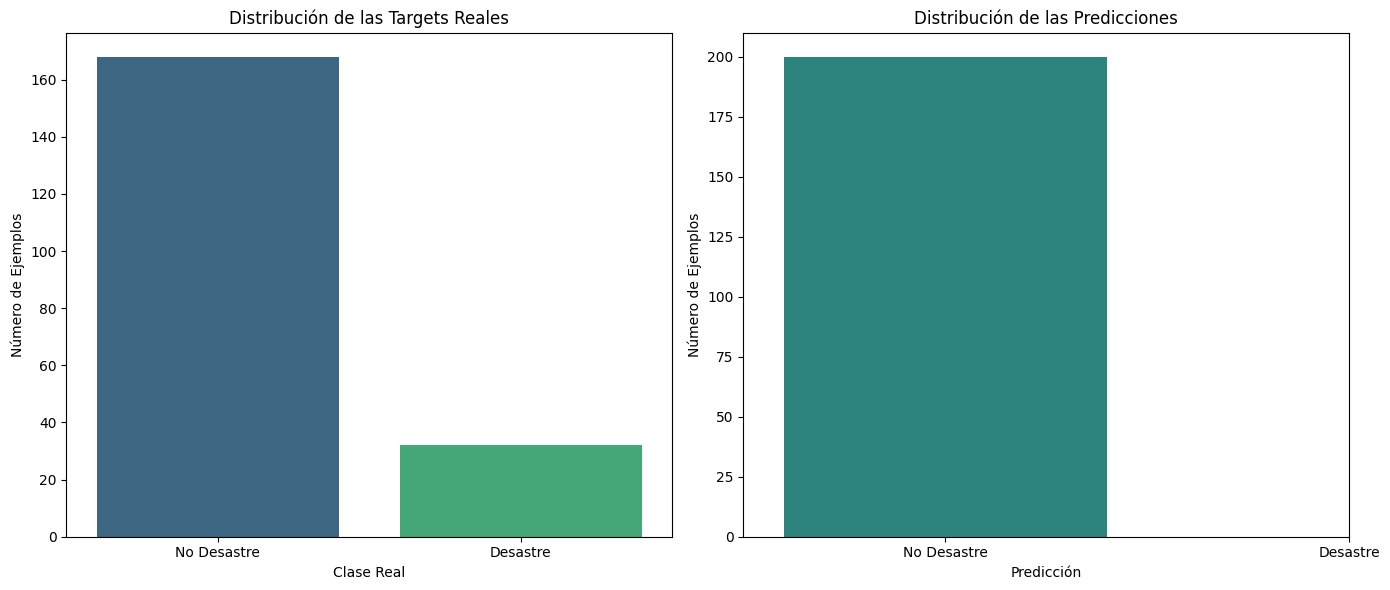

In [15]:
# Graficar el historial de entrenamiento
plt.figure(figsize=(12, 5))

# Graficar la precisión
plt.subplot(1, 2, 1)
plt.plot(historial.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(historial.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión durante el entrenamiento')

# Graficar la pérdida
plt.subplot(1, 2, 2)
plt.plot(historial.history['loss'], label='Pérdida de entrenamiento')
plt.plot(historial.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida durante el entrenamiento')

plt.tight_layout()
plt.show()

# Realizar predicciones en el conjunto de prueba
predicciones = modelo_completo.predict([input_ids_test, attention_masks_test])

# Convertir logits a predicciones de clase (0 o 1)
predicciones_clases = np.argmax(predicciones, axis=1)

# Crear DataFrame con resultados
data_test = pd.DataFrame({'Texto': data['text'].iloc[np.arange(len(input_ids_test))].values,
                          'Real': y_test.numpy(), 'Predicción': predicciones_clases})

# Mostrar las primeras filas del DataFrame
print(data_test.head())

# Graficar distribución de las targets reales y predicciones
plt.figure(figsize=(14, 6))

# Gráfico de la distribución de las targets reales
plt.subplot(1, 2, 1)
sns.countplot(x='Real', data=data_test, palette='viridis')
plt.xlabel('Clase Real')
plt.ylabel('Número de Ejemplos')
plt.title('Distribución de las Targets Reales')
plt.xticks(ticks=[0, 1], labels=['No Desastre', 'Desastre'])  # Añadir etiquetas a las clases

# Gráfico de la distribución de las predicciones
plt.subplot(1, 2, 2)
sns.countplot(x='Predicción', data=data_test, palette='viridis')
plt.xlabel('Predicción')
plt.ylabel('Número de Ejemplos')
plt.title('Distribución de las Predicciones')
plt.xticks(ticks=[0, 1], labels=['No Desastre', 'Desastre'])  # Añadir etiquetas a las clases

plt.tight_layout()
plt.show()


# Resultados
Precisión y Pérdida:

*   Entrenamiento: La precisión aumenta y la pérdida disminuye durante el entrenamiento.
*   Validación: La precisión y la pérdida se mantienen constantes, lo que indica que el modelo no mejora en los datos de validación.

Distribución de Targets y Predicciones:

*   Hay un desbalance significativo entre las clases, con muchos más ejemplos de la clase "No Desastre" en comparación con "Desastre".
*   El modelo predice casi exclusivamente la clase mayoritaria ("No Desastre"), fallando en identificar la clase "Desastre".

Errores de Predicción:

*   Se observan falsos negativos, lo que implica que el modelo no está capturando correctamente los casos de "Desastre", un error crítico en situaciones sensibles.

# Conclusión

El modelo está sobreajustado a los datos de entrenamiento y no generaliza bien a los datos de validación. Además, el desbalance de clases está provocando un sesgo hacia la clase mayoritaria, impidiendo la correcta predicción de eventos de "Desastre". Se recomienda aplicar técnicas de manejo de clases desbalanceadas y regularización para mejorar la capacidad del modelo de predecir correctamente la clase minoritaria y evitar el sobreajuste.